In [1]:
from tensorly.metrics.regression import RMSE
import time
import scipy.io
import tensorly as tl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorly.cp_tensor import CPTensor
from nn_hals_parafac_normalization_comparison import *
import musicntd.model.features as features
import musicntd.data_manipulation as dm
import musicntd.tensor_factory as tf
import soundfile as sf
#audio
data,sampling_rate = sf.read('/home/ctuna/tensoptly/benchmark_data/Audio/The Beatles - Come Together.wav')

#Parameters
rank=10
init='random'
hop_length = 512
n_fft = hop_length * 4
hop_length_seconds = hop_length/sampling_rate


stft_spec = features.get_spectrogram(data[:,0], sampling_rate, 
                                     feature="stft", n_fft = n_fft, hop_length = hop_length)
bars = dm.get_bars_from_audio('/home/ctuna/tensoptly/benchmark_data/Audio/The Beatles - Come Together.wav')

tensor = tf.tensorize_barwise(stft_spec, bars, hop_length_seconds, 40)

/usr/local/lib64/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
/usr/local/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


hop_length a 44100Hz = 512, normal ?


1. Method from PR
2. Inner loop normalization with last factor normalization after inner loop
3. Normalization at the end
4. 2 and 3 together

In [2]:
#normalized improved nonnegative parafac hals result
tic = time.time()
tensornorm1, errorsnorm1, weights_iter1 = nn_hals_normalize1(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True, n_iter_max=100)
weightsnorm1, factorsnorm1 = tensornorm1
cp_reconstructionnorm1 = tl.cp_to_tensor((weightsnorm1, factorsnorm1))
time_cp1 = time.time()-tic

#normalized improved nonnegative parafac hals result
tic = time.time()
tensornorm2, errorsnorm2, weights_iter2 = nn_hals_normalize2(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True, n_iter_max=100)
weightsnorm2, factorsnorm2 = tensornorm2
cp_reconstructionnorm2 = tl.cp_to_tensor((weightsnorm2, factorsnorm2))
time_cp2 = time.time()-tic

#normalized improved nonnegative parafac hals result
tic = time.time()
tensornorm3, errorsnorm3, weights_iter3 = nn_hals_normalize3(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True, n_iter_max=100)
weightsnorm3, factorsnorm3 = tensornorm3
cp_reconstructionnorm3 = tl.cp_to_tensor((weightsnorm3, factorsnorm3))
time_cp3 = time.time()-tic

#normalized improved nonnegative parafac hals result
tic = time.time()
tensornorm4, errorsnorm4, weights_iter4 = nn_hals_normalize4(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True, n_iter_max=100)
weightsnorm4, factorsnorm4 = tensornorm4
cp_reconstructionnorm4 = tl.cp_to_tensor((weightsnorm4, factorsnorm4))
time_cp4 = time.time()-tic

# Error per iteration 

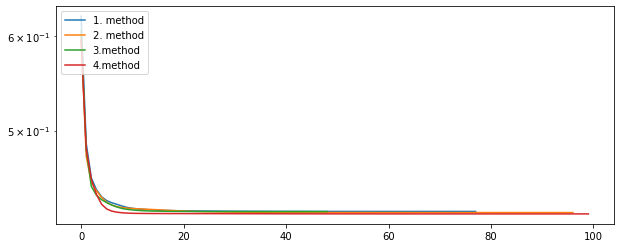

In [3]:
each_iteration(errorsnorm1, errorsnorm2, errorsnorm3, errorsnorm4)

# Weights per iteration 

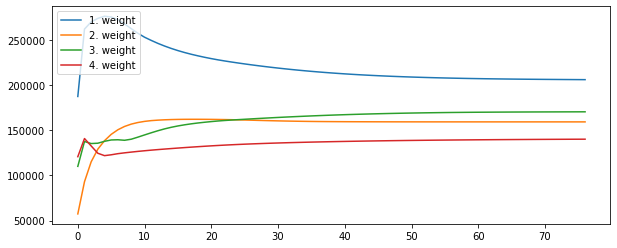

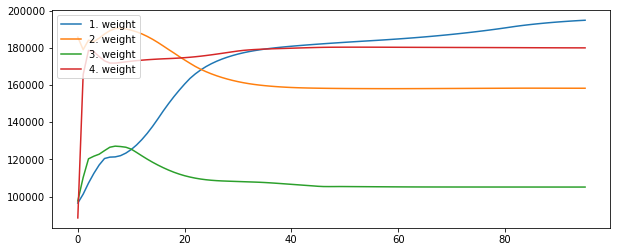

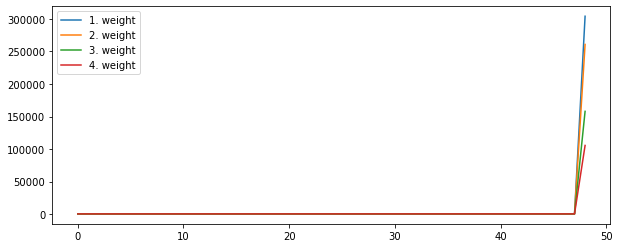

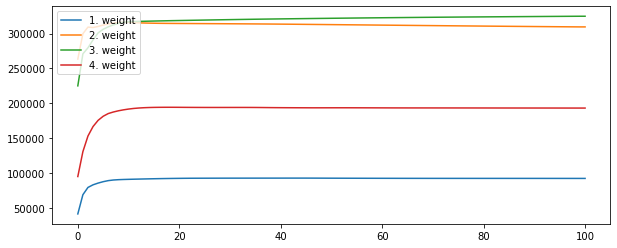

In [4]:
plot_weights(weights_iter1)
plot_weights(weights_iter2)
plot_weights(weights_iter3)
plot_weights(weights_iter4)

# Last weights

In [5]:
print(weightsnorm1[:5])
print(weightsnorm2[:5])
print(weightsnorm3[:5])
print(weightsnorm4[:5])

[205971.62 159252.48 170396.69 140112.83 179814.1 ]
[195085.06 158388.44 105112.18 180145.66 320404.25]
[304189.66 260855.03 158023.28 105593.21 144690.39]
[ 92164.31 309689.97 324990.34 193163.5   99447.58]


# Mean of factors

In [6]:
print(tl.mean(factorsnorm1[0]), tl.mean(factorsnorm1[1]), tl.mean(factorsnorm1[2]))
print(tl.mean(factorsnorm2[0]), tl.mean(factorsnorm2[1]), tl.mean(factorsnorm2[2]))
print(tl.mean(factorsnorm3[0]), tl.mean(factorsnorm3[1]), tl.mean(factorsnorm3[2]))
print(tl.mean(factorsnorm4[0]), tl.mean(factorsnorm4[1]), tl.mean(factorsnorm4[2]))

0.0017374152 0.10774983 0.06706192
0.0017910128 0.1093902 0.062664546
0.0018092023 0.110304795 0.063137285
0.0018439718 0.106053315 0.062139984


In [7]:
print(RMSE(tensor,cp_reconstructionnorm1))
print(RMSE(tensor,cp_reconstructionnorm2))
print(RMSE(tensor,cp_reconstructionnorm3))
print(RMSE(tensor,cp_reconstructionnorm4))

168.89859
168.53078
168.85385
168.09128


In [8]:
print(str(time_cp1))
print(str(time_cp2))
print(str(time_cp3))
print(str(time_cp4))

11.49901819229126
14.525166273117065
9.398605108261108
18.85924005508423
